# Packages

In [1]:
# Data wrangling
import pandas as pd
import polars as pl
import polars.selectors as cs
import numpy as np

# Visualisation
import plotnine as pn
import matplotlib.pyplot as plt
from mizani.formatters import comma_format, custom_format, currency_format, percent_format
from IPython.display import clear_output, display
import matplotlib.font_manager as fm
import matplotlib as mpl
from matplotlib import rc
import plotly.express as px

# Utils
import os
from tqdm.notebook import tqdm
import itertools
import yaml
import warnings
import time
import holidays
import pickle

# Modelling
from sklearn.linear_model import Lasso
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    FunctionTransformer,
)
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_absolute_percentage_error,
    root_mean_squared_error,
    mean_squared_error
)
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import FeatureUnion, make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.feature_selection import VarianceThreshold

from statsmodels.tsa.stattools import acf, pacf, adfuller, kpss

from statsforecast.models import AutoARIMA, ARIMA
from statsforecast.utils import AirPassengers as ap

import ray
from ray import train, tune
from ray.tune.search.optuna import OptunaSearch
from ray.tune.schedulers import ASHAScheduler


rc('text', usetex=False)

jama_colour = [
    "#374e55",
    "#df8f44",
    "#00a1d5",
    "#b24745",
    "#79af97",
    "#6a6599",
    "#80796b",
]

pd.set_option("display.max.columns", 500)
pd.set_option("display.max.columns", 500)


theme_academic = pn.theme(
    text=pn.element_text(family="Latin Modern Roman"),
    plot_title=pn.element_text(weight="bold", size=14, ha="center"),
    legend_text=pn.element_text(size=9),  # Smaller font for legend items
    panel_background=pn.element_rect(fill="white"),  # Clean white background
    panel_border=pn.element_rect(color="grey", size=0.5),
    axis_ticks=pn.element_line(color="grey"),
    panel_grid_major=pn.element_line(color="grey", size=0.1, alpha=0.3),
    panel_grid_minor=pn.element_line(color="grey", size=0.1, alpha=0.3),
    legend_background=pn.element_rect(fill="white", color=None),
    legend_key=pn.element_rect(fill="white", color=None),
    plot_margin=0.02,
    figure_size=(6, 4),  # Set default figure size (width, height in inches)
)

%matplotlib inline

# Loading the data

In [2]:
df = pl.read_csv(
    "../0_data/preprocessed/df_final_reduced.csv", try_parse_dates=True
).filter(pl.col("datetime") >= pd.Timestamp("2021-09-01 00:00"))

df.head()

datetime,kWh,Zurich_shortwave_radiation,Zurich_soil_temperature_7_to_28cm
datetime[μs],f64,f64,f64
2021-09-01 00:00:00,5.1633e6,0.0,16.042
2021-09-01 01:00:00,5.0777e6,0.0,15.892
2021-09-01 02:00:00,4.9315e6,0.0,16.042
2021-09-01 03:00:00,4.7878e6,0.0,15.942
2021-09-01 04:00:00,4.7038e6,0.0,15.792001


In [3]:
df.shape

(26304, 4)

In [4]:
df

datetime,kWh,Zurich_shortwave_radiation,Zurich_soil_temperature_7_to_28cm
datetime[μs],f64,f64,f64
2021-09-01 00:00:00,5.1633e6,0.0,16.042
2021-09-01 01:00:00,5.0777e6,0.0,15.892
2021-09-01 02:00:00,4.9315e6,0.0,16.042
2021-09-01 03:00:00,4.7878e6,0.0,15.942
2021-09-01 04:00:00,4.7038e6,0.0,15.792001
…,…,…,…
2024-08-31 19:00:00,5.3614e6,179.0,22.942
2024-08-31 20:00:00,5.3775e6,41.0,23.042
2024-08-31 21:00:00,5.2130e6,0.0,23.092


# Missing values

Just forward fill for now.

In [5]:
df = df.fill_null(strategy="forward")

# Calendar Features

In [6]:
df = df.with_columns(
    day_of_month=pl.col("datetime").dt.day(),
    day_of_year=pl.col("datetime").dt.ordinal_day(),
    day_of_week=pl.col("datetime").dt.weekday(),
    month=pl.col("datetime").dt.month(),
    hour=pl.col("datetime").dt.hour(),
)

df.head()

datetime,kWh,Zurich_shortwave_radiation,Zurich_soil_temperature_7_to_28cm,day_of_month,day_of_year,day_of_week,month,hour
datetime[μs],f64,f64,f64,i8,i16,i8,i8,i8
2021-09-01 00:00:00,5.1633e6,0.0,16.042,1,244,3,9,0
2021-09-01 01:00:00,5.0777e6,0.0,15.892,1,244,3,9,1
2021-09-01 02:00:00,4.9315e6,0.0,16.042,1,244,3,9,2
2021-09-01 03:00:00,4.7878e6,0.0,15.942,1,244,3,9,3
2021-09-01 04:00:00,4.7038e6,0.0,15.792001,1,244,3,9,4


# Holidays

In [7]:
# Define the region (Canton of Berne) and the country (Switzerland)
country = "CH"
prov = "ZH"

# Create a list of the regional holidays for the canton of Berne
regional_holidays = holidays.CH(
    years=df["datetime"].dt.year().unique().to_list(), prov=prov
)

holiday_df = pl.DataFrame(
    {
        "holiday_name": list(regional_holidays.values()),
        "holiday_date": list(regional_holidays.keys()),
    }
).sort("holiday_date")

holiday_df["holiday_name"].value_counts()

holiday_name,count
str,u32
"""Tag der Arbeit""",4
"""Berchtoldstag""",4
"""Ostermontag""",4
"""Auffahrt""",4
"""Weihnachten""",4
"""Karfreitag""",4
"""Stephanstag""",4
"""Neujahrestag""",4
"""Nationalfeiertag""",4


In [8]:
# Define holiday names
holiday_names = [
    # Osterferienzeit (Easter Holiday Season)
    "Osterferienzeit_1",
    "Osterferienzeit_2",
    "Osterferienzeit_3",
    "Osterferienzeit_4",
    "Osterferienzeit_5",
    # Auffahrtferienzeit (Ascension Holiday Season)
    "Auffahrtferienzeit_1",
    "Auffahrtferienzeit_2",
    "Auffahrtferienzeit_3",
    "Auffahrtferienzeit_4",
    "Auffahrtferienzeit_5",
]

# Repeat holiday names for each year
holiday_names_full = holiday_names * 4

# Define holiday dates
holiday_dates = [
    # 2021
    "2021-03-31",
    "2021-04-01",
    "2021-04-02",
    "2021-04-03",
    "2021-04-04",
    "2021-05-12",
    "2021-05-13",
    "2021-05-14",
    "2021-05-15",
    "2021-05-16",
    # 2022
    "2022-04-13",
    "2022-04-14",
    "2022-04-15",
    "2022-04-16",
    "2022-04-17",
    "2022-05-25",
    "2022-05-26",
    "2022-05-27",
    "2022-05-28",
    "2022-05-29",
    # 2023
    "2023-04-05",
    "2023-04-06",
    "2023-04-07",
    "2023-04-08",
    "2023-04-09",
    "2023-05-17",
    "2023-05-18",
    "2023-05-19",
    "2023-05-20",
    "2023-05-21",
    # 2024
    "2024-03-27",
    "2024-03-28",
    "2024-03-29",
    "2024-03-30",
    "2024-03-31",
    "2024-05-08",
    "2024-05-09",
    "2024-05-10",
    "2024-05-11",
    "2024-05-12",
]

# Create the DataFrame
holiday_manual_df = pl.DataFrame(
    {
        "holiday_name": holiday_names_full,
        "holiday_date": holiday_dates,
    }
).with_columns(
    pl.col("holiday_date").str.to_date()
)  # Define holiday names
holiday_names = [
    # Osterferienzeit (Easter Holiday Season)
    "Osterferienzeit_1",
    "Osterferienzeit_2",
    "Osterferienzeit_3",
    "Osterferienzeit_4",
    "Osterferienzeit_5",
    # Auffahrtferienzeit (Ascension Holiday Season)
    "Auffahrtferienzeit_1",
    "Auffahrtferienzeit_2",
    "Auffahrtferienzeit_3",
    "Auffahrtferienzeit_4",
    "Auffahrtferienzeit_5",
]

# Repeat holiday names for each year
holiday_names_full = holiday_names * 4

# Define holiday dates
holiday_dates = [
    # 2021
    "2021-03-31",
    "2021-04-01",
    "2021-04-02",
    "2021-04-03",
    "2021-04-04",
    "2021-05-12",
    "2021-05-13",
    "2021-05-14",
    "2021-05-15",
    "2021-05-16",
    # 2022
    "2022-04-13",
    "2022-04-14",
    "2022-04-15",
    "2022-04-16",
    "2022-04-17",
    "2022-05-25",
    "2022-05-26",
    "2022-05-27",
    "2022-05-28",
    "2022-05-29",
    # 2023
    "2023-04-05",
    "2023-04-06",
    "2023-04-07",
    "2023-04-08",
    "2023-04-09",
    "2023-05-17",
    "2023-05-18",
    "2023-05-19",
    "2023-05-20",
    "2023-05-21",
    # 2024
    "2024-03-27",
    "2024-03-28",
    "2024-03-29",
    "2024-03-30",
    "2024-03-31",
    "2024-05-08",
    "2024-05-09",
    "2024-05-10",
    "2024-05-11",
    "2024-05-12",
]

# Create the DataFrame
holiday_manual_df = pl.DataFrame(
    {
        "holiday_name": holiday_names_full,
        "holiday_date": holiday_dates,
    }
).with_columns(pl.col("holiday_date").str.to_date())

In [9]:
holiday_df = (
    pl.concat(
        [
            holiday_df,
            holiday_manual_df,
        ],
        how="vertical",
    )
    .sort("holiday_date")
    .unique("holiday_date")
)

In [10]:
df = (
    df.with_columns(date=pl.col("datetime").dt.date())
    .join(holiday_df, how="left", left_on="date", right_on="holiday_date")
    .drop("date")
    .with_columns(holiday_name=pl.col("holiday_name").fill_null("no_holiday"))
)

df.head()

datetime,kWh,Zurich_shortwave_radiation,Zurich_soil_temperature_7_to_28cm,day_of_month,day_of_year,day_of_week,month,hour,holiday_name
datetime[μs],f64,f64,f64,i8,i16,i8,i8,i8,str
2021-09-01 00:00:00,5.1633e6,0.0,16.042,1,244,3,9,0,"""no_holiday"""
2021-09-01 01:00:00,5.0777e6,0.0,15.892,1,244,3,9,1,"""no_holiday"""
2021-09-01 02:00:00,4.9315e6,0.0,16.042,1,244,3,9,2,"""no_holiday"""
2021-09-01 03:00:00,4.7878e6,0.0,15.942,1,244,3,9,3,"""no_holiday"""
2021-09-01 04:00:00,4.7038e6,0.0,15.792001,1,244,3,9,4,"""no_holiday"""


# Cyclical Encoding

In [11]:
def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))


def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))


def encode_cyclically(column_name, periodicity, table):
    # Create sin and cos encoding
    table = table.with_columns(
        sin_transformer(periodicity)
        .fit_transform(table[column_name])
        .alias(f"{column_name}_sin")
    )

    table = table.with_columns(
        cos_transformer(periodicity)
        .fit_transform(table[column_name])
        .alias(f"{column_name}_cos")
    )
    # Drop the old column
    table = table.drop(column_name)

    return table

In [12]:
# Dictionary with column name and calendar periodicity
calendar_features = {
    "day_of_month": 31,
    "day_of_year": 365,
    "day_of_week": 7,
    "month": 12,
    "hour": 24,
}

for column_name, periodicity in calendar_features.items():
    df = encode_cyclically(column_name, periodicity, df)

# sklearn Pipeline

In [13]:
cat_cols = ["holiday_name"]

num_cols = df.select(
    cs.contains(
        "soil_temperature_7_to_28cm",
        "shortwave_radiation",
    )
).columns

manual_cols = df.select(pl.selectors.contains("_cos", "_sin", "is_")).columns

In [14]:
df.drop(manual_cols + cat_cols + num_cols)

datetime,kWh
datetime[μs],f64
2021-09-01 00:00:00,5.1633e6
2021-09-01 01:00:00,5.0777e6
2021-09-01 02:00:00,4.9315e6
2021-09-01 03:00:00,4.7878e6
2021-09-01 04:00:00,4.7038e6
…,…
2024-08-31 19:00:00,5.3614e6
2024-08-31 20:00:00,5.3775e6
2024-08-31 21:00:00,5.2130e6


In [15]:
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="mean")), ("scaler", StandardScaler())]
)

In [16]:
categorical_transformer = Pipeline(
    steps=[
        (
            "encoder",
            OneHotEncoder(sparse_output=False, handle_unknown="ignore"),
        ),
    ]
)

In [17]:
column_transformer = ColumnTransformer(
    transformers=[
        ("numeric", numeric_transformer, num_cols),
        ("categorical", categorical_transformer, cat_cols),
    ],
    remainder="passthrough",
)

In [18]:
preprocessor = Pipeline(
    steps=[
        ("column_transformer", column_transformer),
        (
            "variance_threshold",
            VarianceThreshold(threshold=0.0),
        ),  # Drops constant columns after transformations
    ]
)

# Autocorrelation Visualisation

## No differencing

In [19]:
time_series = df.to_pandas()["kWh"]
acf_lags = 7 * 52

acf_x = acf(time_series, nlags=acf_lags, alpha=0.05)

acf_vals, acf_conf_int = acf_x[:2]

acf_df = pd.DataFrame(
    {
        "ACF": acf_vals,
        "ACF_low": acf_conf_int[:, 0],
        "ACF_high": acf_conf_int[:, 1],
        "Lag": np.arange(0, acf_lags + 1),
    }
)

acf_df.head()

,ACF,ACF_low,ACF_high,Lag
0,1.000000,1.000000,1.000000,0
1,0.972902,0.960817,0.984987,1
2,0.907338,0.886783,0.927893,2
3,0.823625,0.797877,0.849373,3
4,0.736739,0.707394,0.766083,4


findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin

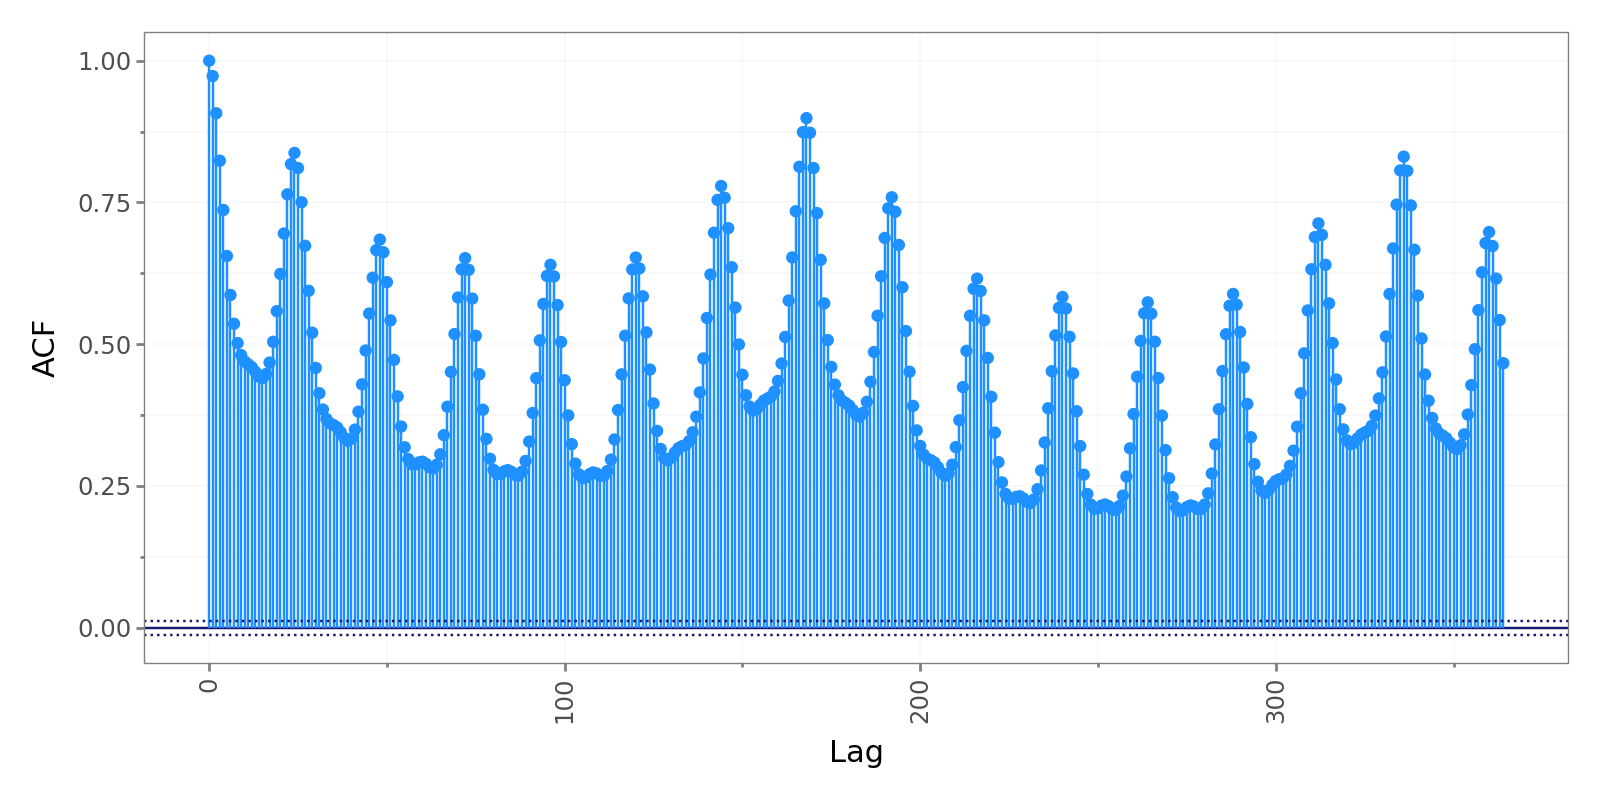

In [20]:
significance_thr = 1.96 / np.sqrt(len(time_series))

(
    pn.ggplot(acf_df, pn.aes(x="Lag", y="ACF"))
    + pn.geom_hline(yintercept=0, color="midnightblue")
    + pn.geom_segment(pn.aes(x="Lag", xend="Lag", y=0, yend="ACF"), color="dodgerblue")
    + pn.geom_point(
        color="dodgerblue",
    )
    + pn.geom_hline(
        yintercept=significance_thr, linetype="dotted", color="midnightblue"
    )
    + pn.geom_hline(
        yintercept=-significance_thr, linetype="dotted", color="midnightblue"
    )
    + theme_academic
    + pn.theme(axis_text_x=pn.element_text(rotation=90), figure_size=(8, 4))
)

In [21]:
pacf_x = pacf(time_series, nlags=acf_lags, alpha=0.05)

pacf_vals, pacf_conf_int = pacf_x[:2]

pacf_df = pd.DataFrame(
    {
        "PACF": pacf_vals,
        "PACF_low": pacf_conf_int[:, 0],
        "PACF_high": pacf_conf_int[:, 1],
        "Lag": np.arange(0, acf_lags + 1),
    }
)

pacf_df.head()

,PACF,PACF_low,PACF_high,Lag
0,1.000000,1.000000,1.000000,0
1,0.972939,0.960854,0.985024,1
2,-0.734299,-0.746384,-0.722215,2
3,0.285290,0.273205,0.297374,3
4,-0.003155,-0.015240,0.008930,4


findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin

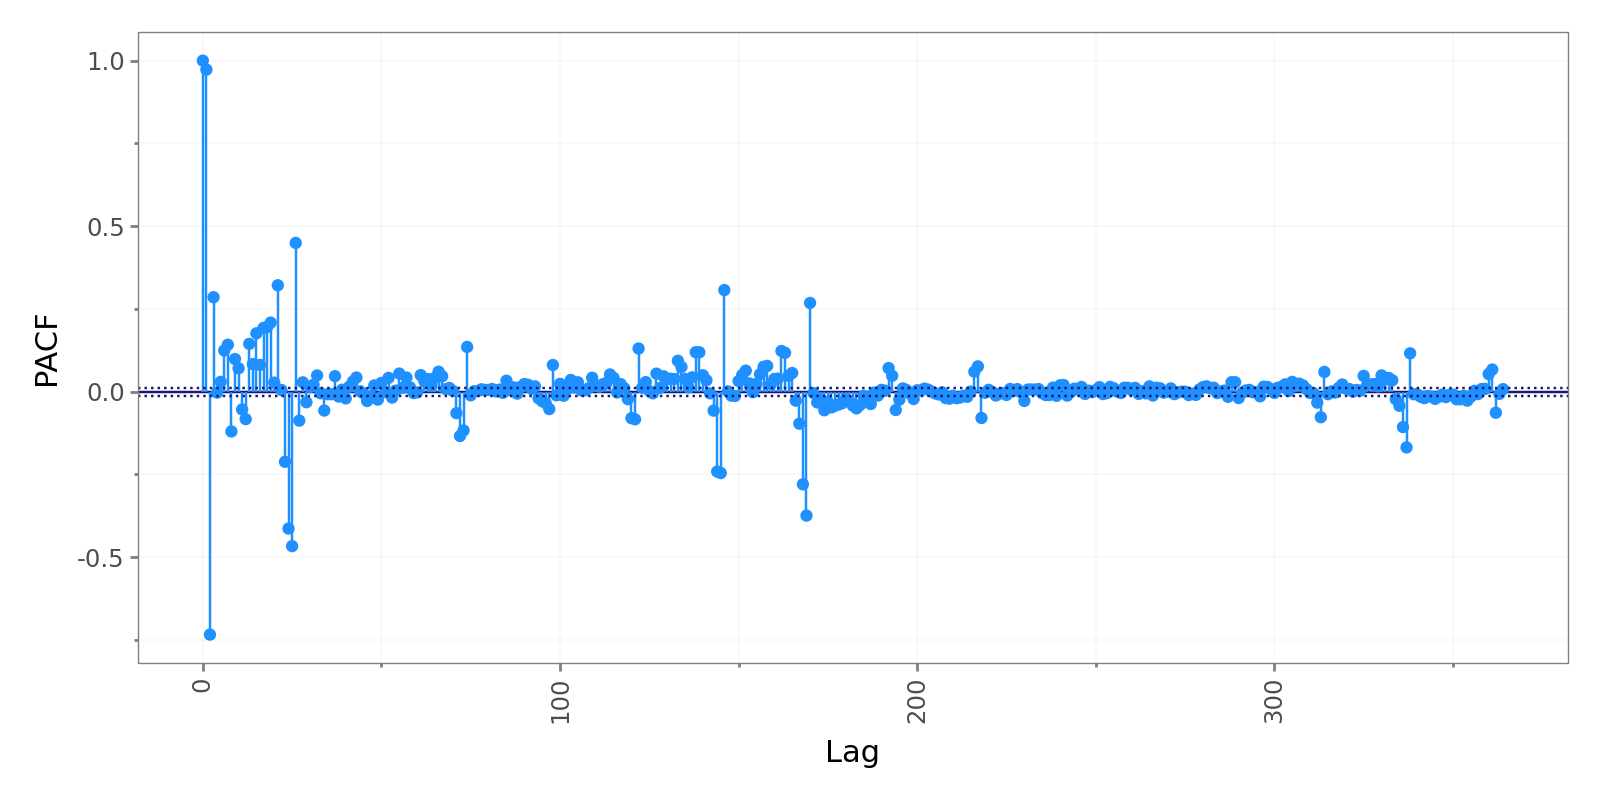

In [22]:
significance_thr = 1.96 / np.sqrt(len(time_series))

(
    pn.ggplot(pacf_df, pn.aes(x="Lag", y="PACF"))
    + pn.geom_hline(yintercept=0, color="midnightblue")
    + pn.geom_segment(pn.aes(x="Lag", xend="Lag", y=0, yend="PACF"), color="dodgerblue")
    + pn.geom_point(
        color="dodgerblue",
    )
    + pn.geom_hline(
        yintercept=significance_thr, linetype="dotted", color="midnightblue"
    )
    + pn.geom_hline(
        yintercept=-significance_thr, linetype="dotted", color="midnightblue"
    )
    + theme_academic
    + pn.theme(axis_text_x=pn.element_text(rotation=90), figure_size=(8, 4))
)

In [23]:
def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

In [24]:
kpss_test(time_series)

C:\Users\STEIM\AppData\Local\Temp\ipykernel_20100\11026176.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.



Results of KPSS Test:
Test Statistic            3.932698
p-value                   0.010000
Lags Used                86.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


## First order differencing

In [25]:
time_series = df.to_pandas()["kWh"]
time_series = (time_series - time_series.shift(1)).dropna()

acf_x = acf(time_series, nlags=acf_lags, alpha=0.05)

acf_vals, acf_conf_int = acf_x[:2]

acf_df = pd.DataFrame(
    {
        "ACF": acf_vals,
        "ACF_low": acf_conf_int[:, 0],
        "ACF_high": acf_conf_int[:, 1],
        "Lag": np.arange(0, acf_lags + 1),
    }
)

acf_df.head()

,ACF,ACF_low,ACF_high,Lag
0,1.000000,1.000000,1.000000,0
1,0.711018,0.698934,0.723103,1
2,0.335399,0.318261,0.352537,2
3,0.058688,0.040617,0.076759,3
4,-0.106215,-0.124315,-0.088116,4


findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin

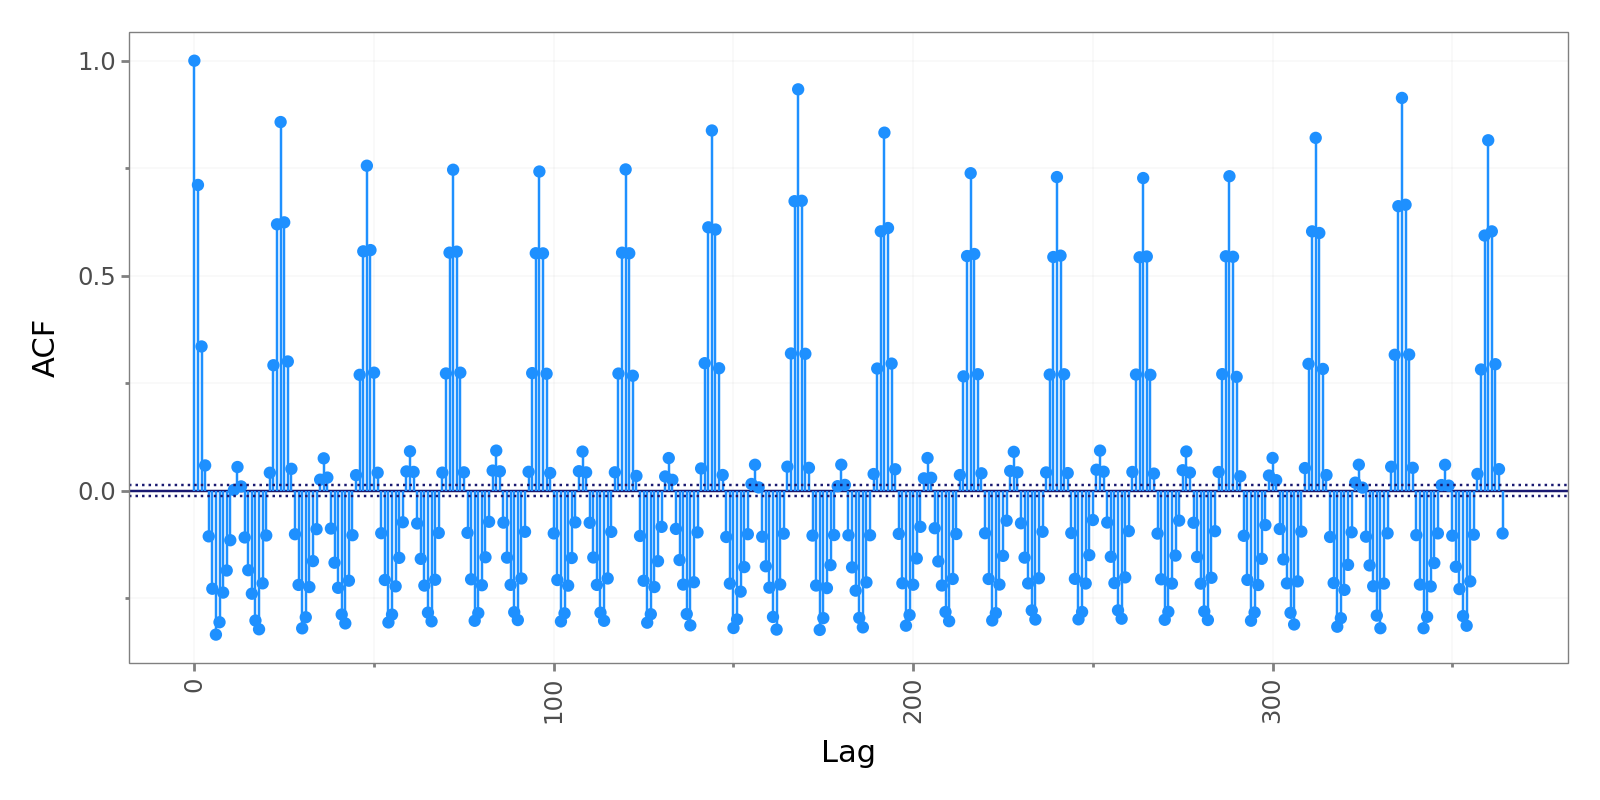

In [26]:
significance_thr = 1.96 / np.sqrt(len(time_series))

(
    pn.ggplot(acf_df, pn.aes(x="Lag", y="ACF"))
    + pn.geom_hline(yintercept=0, color="midnightblue")
    + pn.geom_segment(pn.aes(x="Lag", xend="Lag", y=0, yend="ACF"), color="dodgerblue")
    + pn.geom_point(
        color="dodgerblue",
    )
    + pn.geom_hline(
        yintercept=significance_thr, linetype="dotted", color="midnightblue"
    )
    + pn.geom_hline(
        yintercept=-significance_thr, linetype="dotted", color="midnightblue"
    )
    + theme_academic
    + pn.theme(axis_text_x=pn.element_text(rotation=90), figure_size=(8, 4))
)

In [27]:
pacf_x = pacf(time_series, nlags=acf_lags, alpha=0.05)

pacf_vals, pacf_conf_int = pacf_x[:2]

pacf_df = pd.DataFrame(
    {
        "PACF": pacf_vals,
        "PACF_low": pacf_conf_int[:, 0],
        "PACF_high": pacf_conf_int[:, 1],
        "Lag": np.arange(0, acf_lags + 1),
    }
)

pacf_df.head()

,PACF,PACF_low,PACF_high,Lag
0,1.000000,1.000000,1.000000,0
1,0.711046,0.698961,0.723130,1
2,-0.344167,-0.356252,-0.332082,2
3,-0.039404,-0.051489,-0.027319,3
4,-0.070561,-0.082645,-0.058476,4


findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin

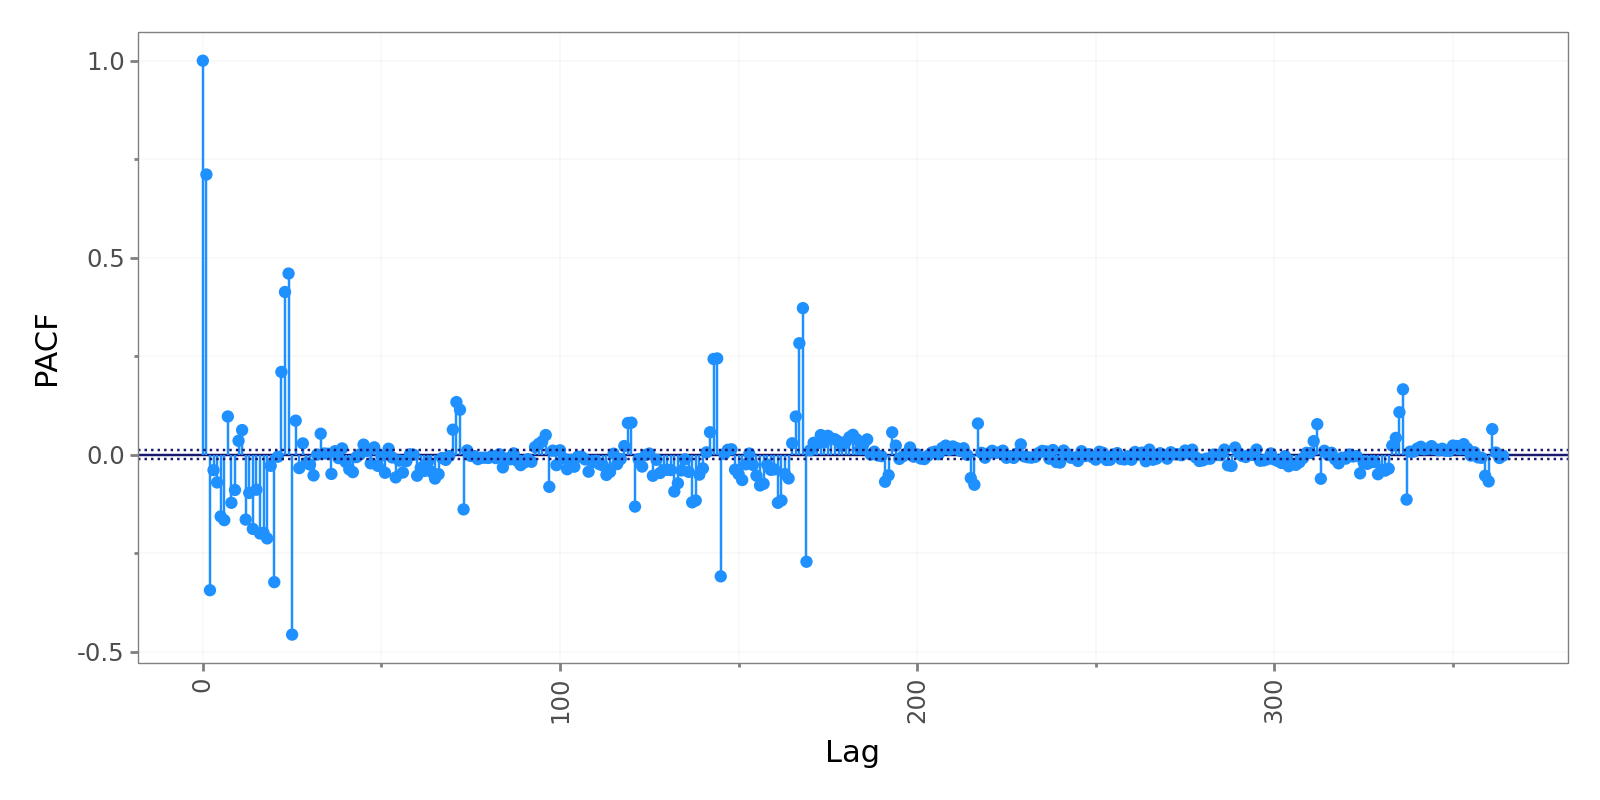

In [28]:
significance_thr = 1.96 / np.sqrt(len(time_series))

(
    pn.ggplot(pacf_df, pn.aes(x="Lag", y="PACF"))
    + pn.geom_hline(yintercept=0, color="midnightblue")
    + pn.geom_segment(pn.aes(x="Lag", xend="Lag", y=0, yend="PACF"), color="dodgerblue")
    + pn.geom_point(
        color="dodgerblue",
    )
    + pn.geom_hline(
        yintercept=significance_thr, linetype="dotted", color="midnightblue"
    )
    + pn.geom_hline(
        yintercept=-significance_thr, linetype="dotted", color="midnightblue"
    )
    + theme_academic
    + pn.theme(axis_text_x=pn.element_text(rotation=90), figure_size=(8, 4))
)

In [29]:
kpss_test(time_series)

Results of KPSS Test:
Test Statistic             0.023294
p-value                    0.100000
Lags Used                379.000000
Critical Value (10%)       0.347000
Critical Value (5%)        0.463000
Critical Value (2.5%)      0.574000
Critical Value (1%)        0.739000
dtype: float64


C:\Users\STEIM\AppData\Local\Temp\ipykernel_20100\11026176.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.



## Second order differencing

In [30]:
time_series = df.to_pandas()["kWh"]
time_series = (time_series - time_series.shift(1)).dropna()
time_series = (time_series - time_series.shift(1)).dropna()

acf_x = acf(time_series, nlags=acf_lags, alpha=0.05)

acf_vals, acf_conf_int = acf_x[:2]

acf_df = pd.DataFrame(
    {
        "ACF": acf_vals,
        "ACF_low": acf_conf_int[:, 0],
        "ACF_high": acf_conf_int[:, 1],
        "Lag": np.arange(0, acf_lags + 1),
    }
)

acf_df.head()

,ACF,ACF_low,ACF_high,Lag
0,1.000000,1.000000,1.000000,0
1,0.149948,0.137862,0.162033,1
2,-0.171152,-0.183506,-0.158798,2
3,-0.193418,-0.206114,-0.180723,3
4,-0.074484,-0.087603,-0.061365,4


findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin

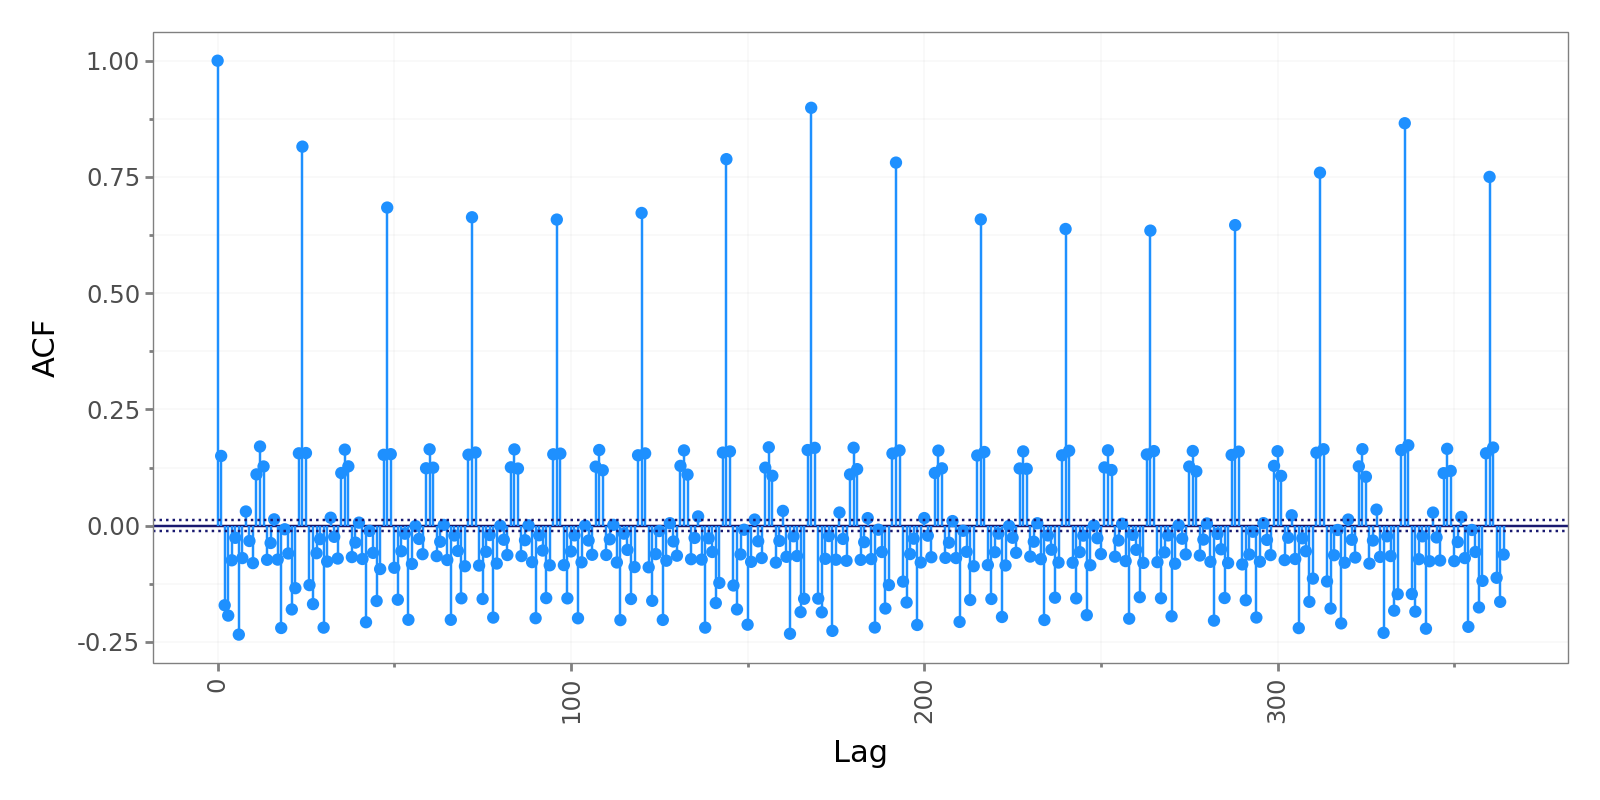

In [31]:
significance_thr = 1.96 / np.sqrt(len(time_series))

(
    pn.ggplot(acf_df, pn.aes(x="Lag", y="ACF"))
    + pn.geom_hline(yintercept=0, color="midnightblue")
    + pn.geom_segment(pn.aes(x="Lag", xend="Lag", y=0, yend="ACF"), color="dodgerblue")
    + pn.geom_point(
        color="dodgerblue",
    )
    + pn.geom_hline(
        yintercept=significance_thr, linetype="dotted", color="midnightblue"
    )
    + pn.geom_hline(
        yintercept=-significance_thr, linetype="dotted", color="midnightblue"
    )
    + theme_academic
    + pn.theme(axis_text_x=pn.element_text(rotation=90), figure_size=(8, 4))
)

In [32]:
pacf_x = pacf(time_series, nlags=acf_lags, alpha=0.05)

pacf_vals, pacf_conf_int = pacf_x[:2]

pacf_df = pd.DataFrame(
    {
        "PACF": pacf_vals,
        "PACF_low": pacf_conf_int[:, 0],
        "PACF_high": pacf_conf_int[:, 1],
        "Lag": np.arange(0, acf_lags + 1),
    }
)

pacf_df.head()

,PACF,PACF_low,PACF_high,Lag
0,1.000000,1.000000,1.000000,0
1,0.149953,0.137868,0.162038,1
2,-0.198105,-0.210190,-0.186020,2
3,-0.141599,-0.153684,-0.129513,3
4,-0.058120,-0.070206,-0.046035,4


findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin

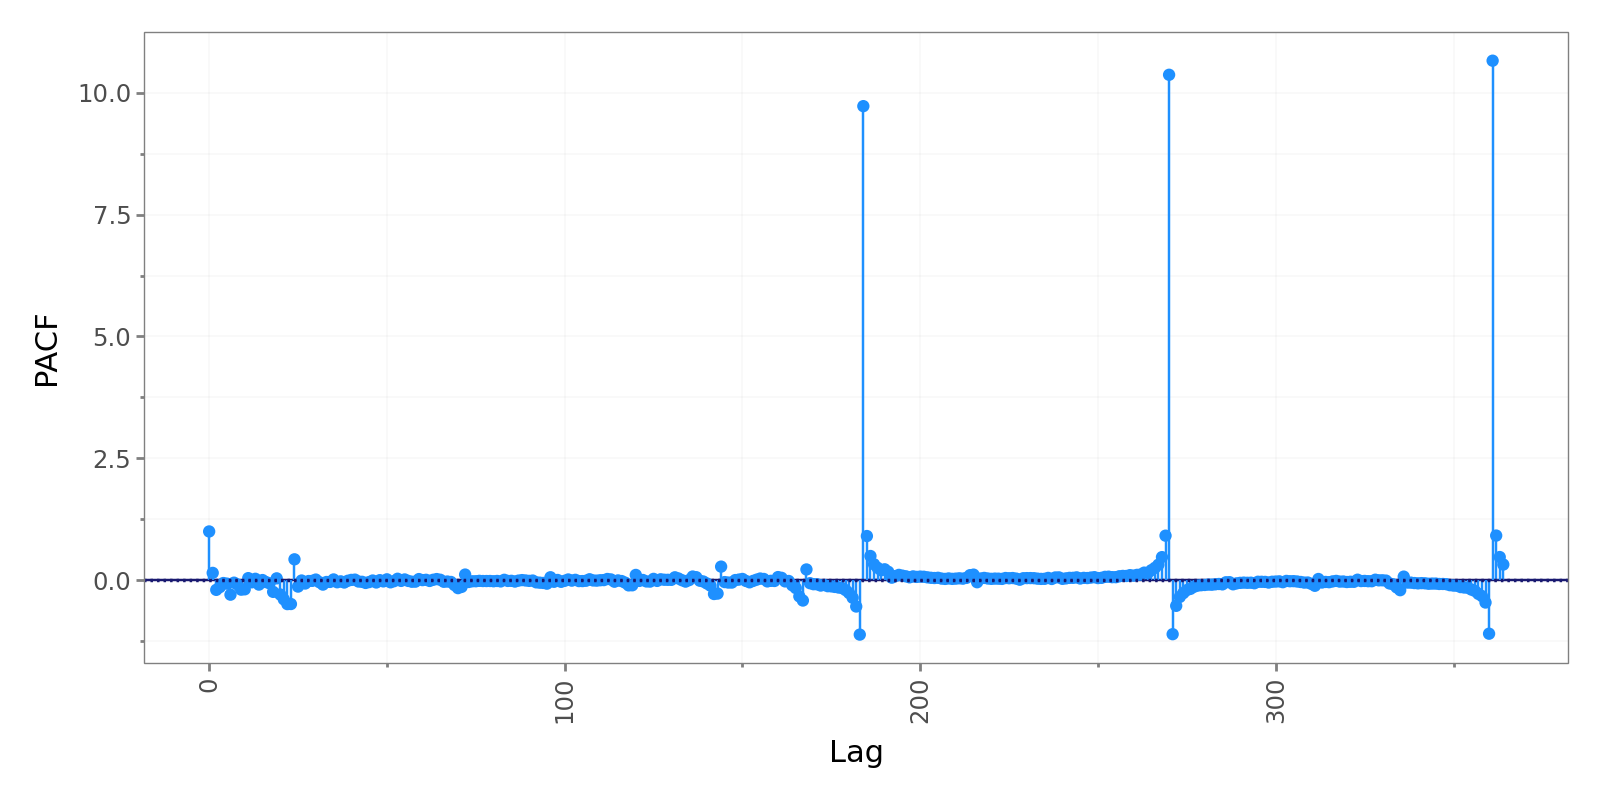

In [33]:
significance_thr = 1.96 / np.sqrt(len(time_series))

(
    pn.ggplot(pacf_df, pn.aes(x="Lag", y="PACF"))
    + pn.geom_hline(yintercept=0, color="midnightblue")
    + pn.geom_segment(pn.aes(x="Lag", xend="Lag", y=0, yend="PACF"), color="dodgerblue")
    + pn.geom_point(
        color="dodgerblue",
    )
    + pn.geom_hline(
        yintercept=significance_thr, linetype="dotted", color="midnightblue"
    )
    + pn.geom_hline(
        yintercept=-significance_thr, linetype="dotted", color="midnightblue"
    )
    + theme_academic
    + pn.theme(axis_text_x=pn.element_text(rotation=90), figure_size=(8, 4))
)

# Order Selection (Parameter Tuning) with `statsforecast`

## Computational complexity extrapolation chart

In [34]:
df_full = (
    df.to_pandas()
    .assign(datetime=lambda x: x.datetime.astype("datetime64[ns]"))
    .set_index("datetime")
    .asfreq("h")
    .sort_index()
)
df_full.head()

,kWh,Zurich_shortwave_radiation,Zurich_soil_temperature_7_to_28cm,holiday_name,day_of_month_sin,day_of_month_cos,day_of_year_sin,day_of_year_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos,hour_sin,hour_cos
datetime,,,,,,,,,,,,,,
2021-09-01 00:00:00,5.163270e+06,0.0,16.042000,no_holiday,0.201299,0.97953,-0.871706,-0.490029,0.433884,-0.900969,-1.0,-1.836970e-16,0.000000,1.000000
2021-09-01 01:00:00,5.077656e+06,0.0,15.892000,no_holiday,0.201299,0.97953,-0.871706,-0.490029,0.433884,-0.900969,-1.0,-1.836970e-16,0.258819,0.965926
2021-09-01 02:00:00,4.931528e+06,0.0,16.042000,no_holiday,0.201299,0.97953,-0.871706,-0.490029,0.433884,-0.900969,-1.0,-1.836970e-16,0.500000,0.866025
2021-09-01 03:00:00,4.787832e+06,0.0,15.942000,no_holiday,0.201299,0.97953,-0.871706,-0.490029,0.433884,-0.900969,-1.0,-1.836970e-16,0.707107,0.707107
2021-09-01 04:00:00,4.703846e+06,0.0,15.792001,no_holiday,0.201299,0.97953,-0.871706,-0.490029,0.433884,-0.900969,-1.0,-1.836970e-16,0.866025,0.500000


In [35]:
# Go a lot smaller on the data to make computation feasible
df_train = df_full["2023-06-01":"2023-06-30"]
df_val = df_full["2023-07-01":"2023-07-31"]

In [36]:
X_train = df_train.drop(columns=["kWh"])
X_val = df_val.drop(columns=["kWh"])

In [37]:
X_train_preprocessed = pd.DataFrame(
    preprocessor.fit_transform(X_train),
    columns=preprocessor.get_feature_names_out(),
)

X_val_preprocessed = pd.DataFrame(
    preprocessor.transform(X_val),
    columns=preprocessor.get_feature_names_out(),
)

y_train = df_train["kWh"]
y_val = df_val["kWh"]

In [38]:
X_train_preprocessed = X_train_preprocessed.apply(pd.to_numeric, errors="coerce")
X_val_preprocessed = X_val_preprocessed.apply(pd.to_numeric, errors="coerce")

In [39]:
n_obs_list = np.arange(200, 700 + 1, 100)
fit_times = []

for n_obs in tqdm(n_obs_list):

    model = ARIMA(
        order=(1, 1, 1),
        season_length=24,
        seasonal_order=(1, 1, 1),
        # include_drift=True
    )

    start_time = time.time()
    model.fit(
        y=y_train.head(n_obs).to_numpy(dtype=np.float64),
        X=X_train_preprocessed.head(n_obs).to_numpy(dtype=np.float64),
    )
    end_time = time.time()
    fit_times.append((end_time - start_time) / 60)

  0%|          | 0/6 [00:00<?, ?it/s]

findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin

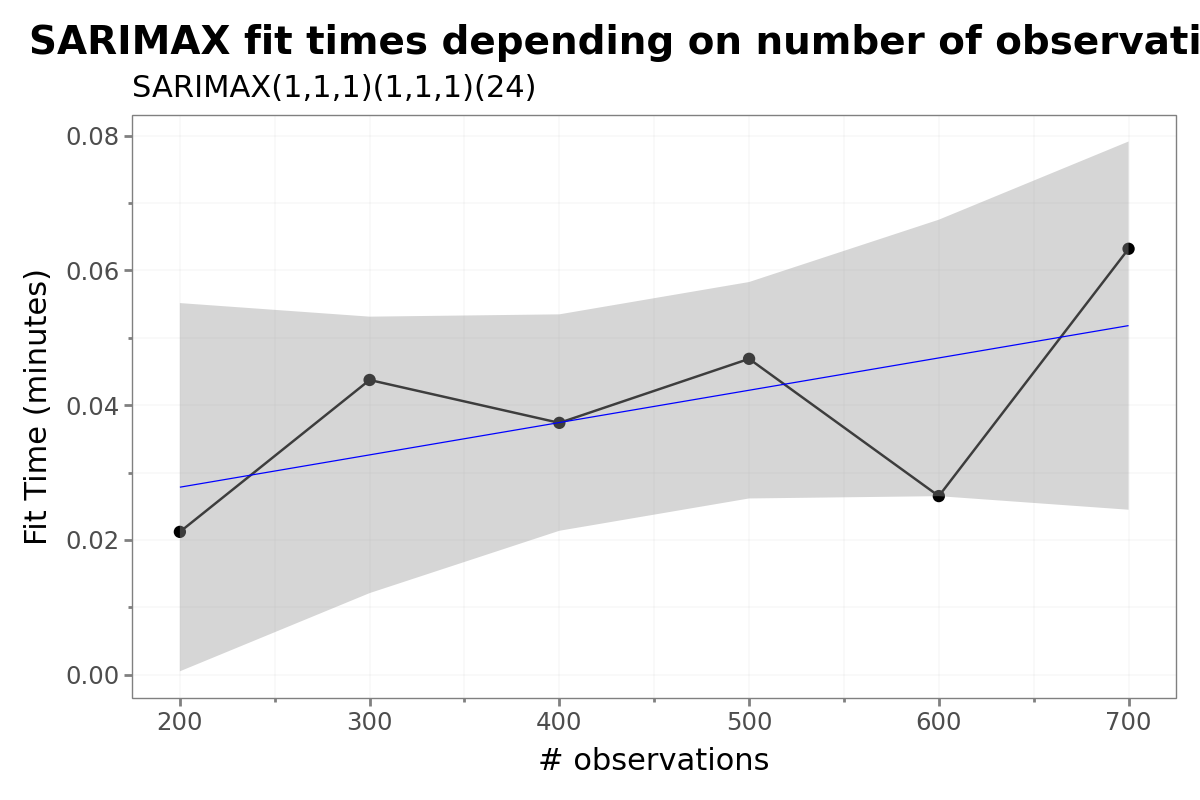

In [40]:
(
    pn.ggplot(
        data=pd.DataFrame({"n": n_obs_list, "fit_time": fit_times}),
        mapping=pn.aes("n", "fit_time"),
    )
    + pn.geom_line()
    + pn.geom_point()
    + pn.labs(
        title="SARIMAX fit times depending on number of observations",
        subtitle="SARIMAX(1,1,1)(1,1,1)(24)",
        x="# observations",
        y="Fit Time (minutes)",
    )
    + pn.geom_smooth(method="lm", colour="blue", size=0.25)
    + theme_academic
)

Extrapolation linearly: SARIMAX on hourly data with this configuration will take (minutes):

In [41]:
df.shape[0] / n_obs_list[-1] * fit_times[-1]

2.3752778756277904

## Manually Fitting a Model

In [42]:
def validation(model, X_train, X_val, y_train, y_val, verbose=True):
    # Validation loop (predict the next 24 hours for the validation period)
    X_train_val = pd.concat([X_train, X_val], axis=0)
    y_train_val = pd.concat([y_train, y_val], axis=0)

    # To prevent function becoming slow due to linearly growing history
    max_history_obs = 168 * 2

    val_index = X_train.shape[0]
    horizon = 24
    val_preds = np.array([])

    while val_index + horizon <= X_train_val.shape[0]:

        y_pred = model.forward(
            y=y_train_val[
                np.amax([0, val_index - max_history_obs]) : val_index
            ].to_numpy(dtype=np.float64),
            h=24,
            X=X_train_val[
                np.amax([0, val_index - max_history_obs]) : val_index
            ].to_numpy(dtype=np.float64),
            X_future=X_train_val[val_index : val_index + horizon].to_numpy(
                dtype=np.float64
            ),
        )["mean"]

        # Append to array
        val_preds = np.append(val_preds, y_pred)

        # Increment validation index
        val_index += horizon

        if (val_position := val_index - X_train.shape[0]) % 24 == 0 and verbose:
            print(f"Hour {val_position} of {X_val.shape[0]}")
            clear_output(wait=True)

    return np.vstack(val_preds).flatten()

In [43]:
df_full = (
    df.to_pandas()
    .assign(
        datetime=lambda x: x.datetime.astype("datetime64[ns]"),
    )
    .set_index("datetime")
    .asfreq("h")
    .sort_index()
)
df_full.head()

,kWh,Zurich_shortwave_radiation,Zurich_soil_temperature_7_to_28cm,holiday_name,day_of_month_sin,day_of_month_cos,day_of_year_sin,day_of_year_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos,hour_sin,hour_cos
datetime,,,,,,,,,,,,,,
2021-09-01 00:00:00,5.163270e+06,0.0,16.042000,no_holiday,0.201299,0.97953,-0.871706,-0.490029,0.433884,-0.900969,-1.0,-1.836970e-16,0.000000,1.000000
2021-09-01 01:00:00,5.077656e+06,0.0,15.892000,no_holiday,0.201299,0.97953,-0.871706,-0.490029,0.433884,-0.900969,-1.0,-1.836970e-16,0.258819,0.965926
2021-09-01 02:00:00,4.931528e+06,0.0,16.042000,no_holiday,0.201299,0.97953,-0.871706,-0.490029,0.433884,-0.900969,-1.0,-1.836970e-16,0.500000,0.866025
2021-09-01 03:00:00,4.787832e+06,0.0,15.942000,no_holiday,0.201299,0.97953,-0.871706,-0.490029,0.433884,-0.900969,-1.0,-1.836970e-16,0.707107,0.707107
2021-09-01 04:00:00,4.703846e+06,0.0,15.792001,no_holiday,0.201299,0.97953,-0.871706,-0.490029,0.433884,-0.900969,-1.0,-1.836970e-16,0.866025,0.500000


In [44]:
# Go a lot smaller on the data to make computation feasible
df_train = df_full["2023-06-01":"2023-06-30"]
df_val = df_full["2023-07-01":"2023-07-31"]

In [45]:
X_train = df_train.drop(columns=["kWh"])
X_val = df_val.drop(columns=["kWh"])

In [46]:
X_train_preprocessed = pd.DataFrame(
    preprocessor.fit_transform(X_train),
    columns=preprocessor.get_feature_names_out(),
)

X_val_preprocessed = pd.DataFrame(
    preprocessor.transform(X_val),
    columns=preprocessor.get_feature_names_out(),
)

y_train = df_train["kWh"]
y_val = df_val["kWh"]

In [47]:
model = ARIMA(
    order=(1, 1, 1),
    season_length=168,
    seasonal_order=(1, 1, 1),
    # include_drift=True
)

model = model.fit(
    y=y_train.to_numpy(dtype=np.float64),
    X=X_train_preprocessed.to_numpy(dtype=np.float64),
)

In [48]:
# this is the setup to predict one day into the future
# without refitting the model

y_preds = model.forward(
    y=y_train.to_numpy(dtype=np.float64),
    h=24,
    X=X_train_preprocessed.to_numpy(dtype=np.float64),
    X_future=X_val_preprocessed.head(24).to_numpy(dtype=np.float64),
)["mean"]

y_preds

array([5005935.82730019, 4781250.01504853, 4650001.54453765,
       4462067.17281081, 4224368.26709773, 4236707.84645389,
       4398182.44135493, 4567910.21457069, 4850335.31117021,
       5054793.04448695, 5109176.06348393, 5179508.25985115,
       5093598.92919599, 4996582.82456709, 4865861.40478137,
       4816804.69730357, 4839402.98658045, 4967936.25161884,
       5120866.84253312, 5118657.69052951, 5036063.91825441,
       4995319.6651304 , 5046642.48320232, 4844974.81538484])

In [49]:
y_pred = validation(
    model=model,
    X_train=X_train_preprocessed,
    X_val=X_val_preprocessed,
    y_train=y_train,
    y_val=y_val,
)


preds_168 = pd.DataFrame(
    {
        "pred": y_pred,
        "kWh": y_val,
    }
)

Hour 744 of 744


In [50]:
# Create the figure with step lines for both actual and predicted values
fig = px.line(
    preds_168.reset_index(),
    x="datetime",
    y=["kWh", "pred"],
    labels={
        "datetime": "Date",
        "value": "Energy Consumption (kWh)",
        "variable": "Series",
    },
    title="Actual vs Predicted Energy Consumption Over Time",
    line_shape="hv",  # Set line shape to horizontal-vertical for step chart
)

# Customize the layout
fig.update_layout(
    template="plotly_white",
    legend=dict(title=""),
    xaxis_title="Date",
    yaxis_title="Energy Consumption (kWh)",
)

# Show the figure
fig.show()

In [51]:
model = ARIMA(
    order=(1, 1, 1),
    season_length=24,
    seasonal_order=(1, 1, 1),
    # include_drift=True
)

model = model.fit(
    y=y_train.to_numpy(dtype=np.float64),
    X=X_train_preprocessed.to_numpy(dtype=np.float64),
)

In [52]:
y_pred = validation(
    model=model,
    X_train=X_train_preprocessed,
    X_val=X_val_preprocessed,
    y_train=y_train,
    y_val=y_val,
)


preds_24 = pd.DataFrame(
    {
        "pred": y_pred,
        "kWh": y_val,
    }
)

Hour 744 of 744


In [53]:
# Create the figure with step lines for both actual and predicted values
fig = px.line(
    preds_24.reset_index(),
    x="datetime",
    y=["kWh", "pred"],
    labels={
        "datetime": "Date",
        "value": "Energy Consumption (kWh)",
        "variable": "Series",
    },
    title="Actual vs Predicted Energy Consumption Over Time",
    line_shape="hv",  # Set line shape to horizontal-vertical for step chart
)

# Customize the layout
fig.update_layout(
    template="plotly_white",
    legend=dict(title=""),
    xaxis_title="Date",
    yaxis_title="Energy Consumption (kWh)",
)

# Show the figure
fig.show()

In [54]:
pd.concat(
    [
        preds_168.assign(seasonality=168).reset_index(),
        preds_24.assign(seasonality=24).reset_index(),
    ],
    axis=0,
).to_csv("3_SARIMAX_seasonality_24_168_comparison.csv", index=False)

findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin

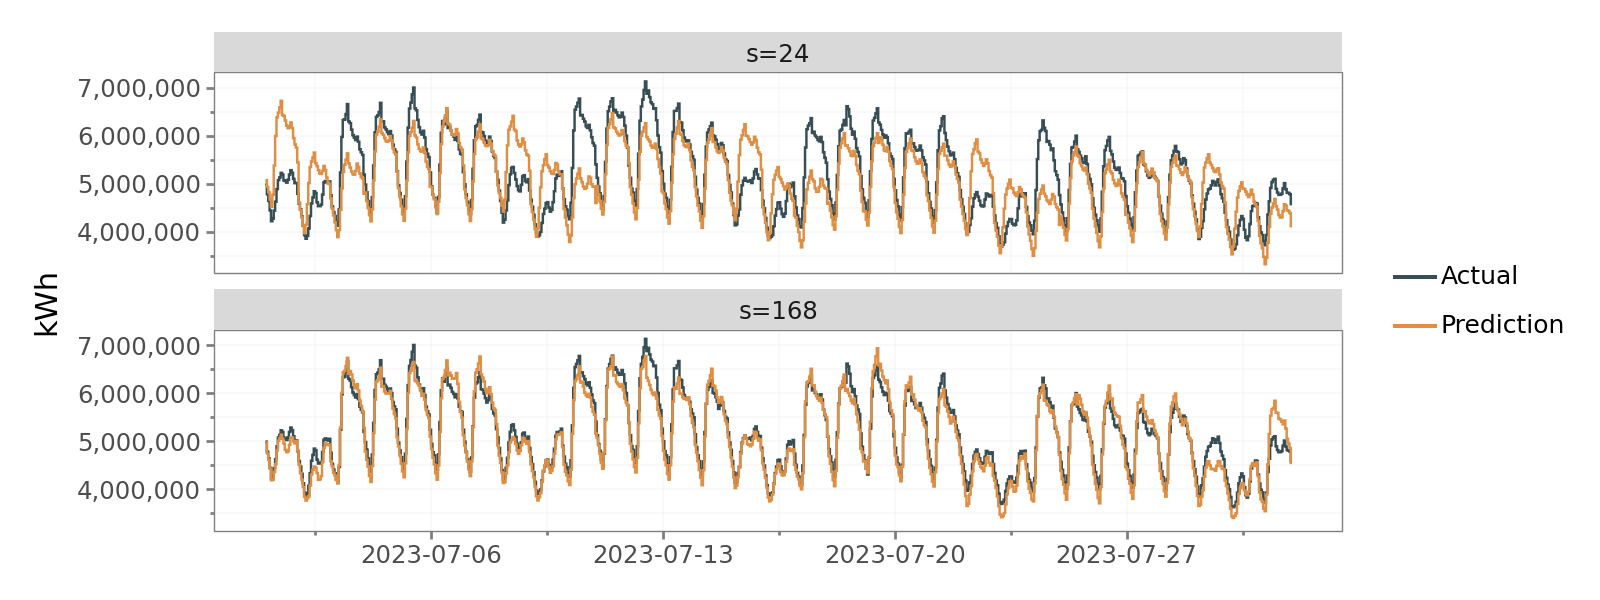

c:\Users\STEIM\.conda\envs\lapro_eth\lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning:

Saving 8 x 3 in image.

c:\Users\STEIM\.conda\envs\lapro_eth\lib\site-packages\plotnine\ggplot.py:607: PlotnineWarning:

Filename: ../1_figures/sarimax_seasonality_24_vs_168.pdf

findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 

In [55]:
plot_width = 8
plot_height = 3

fig = (
    pn.ggplot(
        data=(
            pd.read_csv(
                "3_SARIMAX_seasonality_24_168_comparison.csv", parse_dates=["datetime"]
            )
            .melt(id_vars=["datetime", "seasonality"])
            .assign(
                seasonality=lambda x: pd.Categorical(
                    np.where(x["seasonality"] == 168, "s=168", "s=24"),
                    categories=["s=24", "s=168"],
                    ordered=True,
                ),
                variable=lambda x: np.where(
                    x["variable"] == "pred", "Prediction", "Actual"
                ),
            )
        ),
        mapping=pn.aes("datetime", "value", colour="variable"),
    )
    + pn.geom_step()
    + pn.labs(y="kWh")
    + pn.facet_wrap("~ seasonality", ncol=1)
    + pn.scale_colour_manual(values=jama_colour)
    + pn.scale_x_datetime(date_breaks="1 week")
    + pn.scale_y_continuous(labels=comma_format())
    + theme_academic
    + pn.theme(
        figure_size=(plot_width, plot_height),
        axis_title_x=pn.element_blank(),
        legend_title=pn.element_blank(),
    )
)

display(fig)
fig.save(
    filename="../1_figures/sarimax_seasonality_24_vs_168.pdf",
    width=plot_width,
    height=plot_height,
    dpi=300,
)

## AutoARIMA

Use information criterion to select the model.

In [56]:
df_full = (
    df.to_pandas()
    .assign(datetime=lambda x: x.datetime.astype("datetime64[ns]"))
    .set_index("datetime")
    .asfreq("h")
    .sort_index()
)
df_full.head()

,kWh,Zurich_shortwave_radiation,Zurich_soil_temperature_7_to_28cm,holiday_name,day_of_month_sin,day_of_month_cos,day_of_year_sin,day_of_year_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos,hour_sin,hour_cos
datetime,,,,,,,,,,,,,,
2021-09-01 00:00:00,5.163270e+06,0.0,16.042000,no_holiday,0.201299,0.97953,-0.871706,-0.490029,0.433884,-0.900969,-1.0,-1.836970e-16,0.000000,1.000000
2021-09-01 01:00:00,5.077656e+06,0.0,15.892000,no_holiday,0.201299,0.97953,-0.871706,-0.490029,0.433884,-0.900969,-1.0,-1.836970e-16,0.258819,0.965926
2021-09-01 02:00:00,4.931528e+06,0.0,16.042000,no_holiday,0.201299,0.97953,-0.871706,-0.490029,0.433884,-0.900969,-1.0,-1.836970e-16,0.500000,0.866025
2021-09-01 03:00:00,4.787832e+06,0.0,15.942000,no_holiday,0.201299,0.97953,-0.871706,-0.490029,0.433884,-0.900969,-1.0,-1.836970e-16,0.707107,0.707107
2021-09-01 04:00:00,4.703846e+06,0.0,15.792001,no_holiday,0.201299,0.97953,-0.871706,-0.490029,0.433884,-0.900969,-1.0,-1.836970e-16,0.866025,0.500000


In [57]:
df_train = df_full[:"2023-08-31"]

In [58]:
X_train = df_train.drop(columns=["kWh"])

In [59]:
X_train_preprocessed = pd.DataFrame(
    preprocessor.fit_transform(X_train),
    columns=preprocessor.get_feature_names_out(),
)

y_train = df_train["kWh"]

In [60]:
%%capture
model = AutoARIMA(
    d=1,
    D=1,
    max_p=24,
    max_q=24,
    max_P=1,
    max_Q=1,
    stepwise=True,
    approximation=True,
    trace=True,
    season_length=168,
)

model = model.fit(
    y=y_train.to_numpy(dtype=np.float64),
    X=X_train_preprocessed.to_numpy(dtype=np.float64),
)

In [61]:
# Save the entire model object
with open("autoarima_model.pkl", "wb") as f:
    pickle.dump(model.model_, f)

## Manual Validation for Order Selection

Repeat the same as manual fit (train/val split), but do order selection via fitting all order and selecting the best one (for p,q,P,Q) separately.

In [62]:
df_full = (
    df.to_pandas()
    .assign(datetime=lambda x: x.datetime.astype("datetime64[ns]"))
    .set_index("datetime")
    .asfreq("h")
    .sort_index()
)

In [63]:
# Go a lot smaller on the data to make computation feasible
df_train = df_full["2023-06-01":"2023-06-30"]
df_val = df_full["2023-07-01":"2023-07-31"]

In [64]:
X_train = df_train.drop(columns=["kWh"])
X_val = df_val.drop(columns=["kWh"])

In [65]:
X_train_preprocessed = pd.DataFrame(
    preprocessor.fit_transform(X_train),
    columns=preprocessor.get_feature_names_out(),
)

X_val_preprocessed = pd.DataFrame(
    preprocessor.transform(X_val),
    columns=preprocessor.get_feature_names_out(),
)

y_train = df_train["kWh"]
y_val = df_val["kWh"]

In [66]:
p_search_space = np.arange(0, 24 + 1)
q_search_space = np.arange(0, 24 + 1)
P_search_space = np.arange(0, 1 + 1)
Q_search_space = np.arange(0, 1 + 1)

param_search_spaces = {
    "p": p_search_space,
    "q": q_search_space,
    "P": P_search_space,
    "Q": Q_search_space,
}

y_preds_val = []

for param, search_space in param_search_spaces.items():

    for param_value in tqdm(search_space):

        current_model_config = {"p": 0, "q": 0, "P": 0, "Q": 0}
        current_model_config[param] = int(param_value)

        model = ARIMA(
            order=(current_model_config["p"], 1, current_model_config["q"]),
            season_length=168,
            seasonal_order=(current_model_config["P"], 1, current_model_config["Q"]),
        )

        # Fit the model on the training data
        model = model.fit(
            y=y_train.to_numpy(dtype=np.float64),
            X=X_train_preprocessed.to_numpy(dtype=np.float64),
        )

        # Validate the model performance
        y_pred = validation(
            model=model,
            X_train=X_train_preprocessed,
            X_val=X_val_preprocessed,
            y_train=y_train,
            y_val=y_val,
            verbose=False,
        )

        y_pred = pd.DataFrame(
            {
                "pred": y_pred,
                "kWh": y_val,
            }
        ).assign(
            p=current_model_config["p"],
            q=current_model_config["q"],
            P=current_model_config["P"],
            Q=current_model_config["Q"],
        )

        y_preds_val.append(y_pred)

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [67]:
pd.concat(y_preds_val).to_csv("3_SARIMAX_manual_order_selection.csv", index=False)

findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin

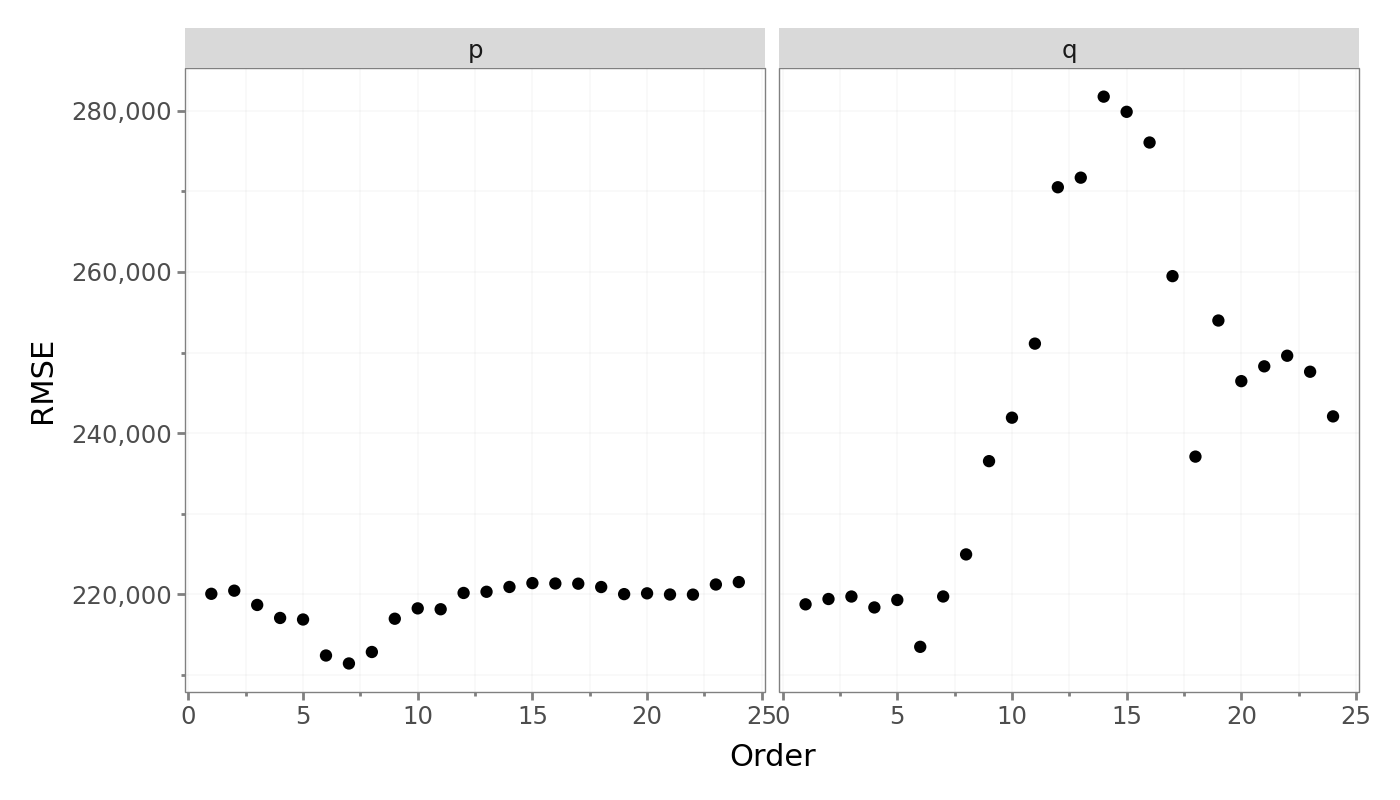

c:\Users\STEIM\.conda\envs\lapro_eth\lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning:

Saving 7 x 4 in image.

c:\Users\STEIM\.conda\envs\lapro_eth\lib\site-packages\plotnine\ggplot.py:607: PlotnineWarning:

Filename: ../1_figures/order_selection_manual_p_and_q.pdf

findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family

In [68]:
plot_width = 7
plot_height = 4

fig = (
    pn.ggplot(
        data=(
            pl.read_csv("3_SARIMAX_manual_order_selection.csv")
            .group_by(["p", "q", "P", "Q"])
            .agg(loss=(pl.col("pred") - pl.col("kWh")).pow(2).mean().sqrt())
            .unpivot(index="loss")
            .filter(pl.col("value") > 0)
            .filter(pl.col("variable").is_in(["p", "q"]))
        ),
        mapping=pn.aes("value", "loss"),
    )
    + pn.geom_point()
    + pn.facet_wrap("~ variable")
    + pn.labs(y="RMSE", x="Order")
    + pn.scale_y_continuous(labels=comma_format())
    + theme_academic
    + pn.theme(figure_size=(plot_width, plot_height), legend_position="bottom")
)

display(fig)
fig.save(
    filename="../1_figures/order_selection_manual_p_and_q.pdf",
    width=plot_width,
    height=plot_height,
    dpi=300,
)

## RayTune Tuning Setup

Repeat the same as manual fit (train/val split), but do order selection via OptunaSearch

In [69]:
df_full = (
    df.to_pandas()
    .assign(datetime=lambda x: x.datetime.astype("datetime64[ns]"))
    .set_index("datetime")
    .asfreq("h")
    .sort_index()
)

In [70]:
# Go a lot smaller on the data to make computation feasible
df_train = df_full["2023-06-01":"2023-06-30"]
df_val = df_full["2023-07-01":"2023-07-31"]

In [71]:
X_train = df_train.drop(columns=["kWh"])
X_val = df_val.drop(columns=["kWh"])

In [72]:
X_train_preprocessed = pd.DataFrame(
    preprocessor.fit_transform(X_train),
    columns=preprocessor.get_feature_names_out(),
)

X_val_preprocessed = pd.DataFrame(
    preprocessor.transform(X_val),
    columns=preprocessor.get_feature_names_out(),
)

y_train = df_train["kWh"]
y_val = df_val["kWh"]

In [73]:
def sarimax_trainable(config, df_train, df_val):

    try:
        # Initialize the ARIMA model with the given configuration
        model = ARIMA(
            order=(config["p"], config["d"], config["q"]),
            season_length=168,
            seasonal_order=(config["P"], config["D"], config["Q"]),
        )

        # Fit the model on the training data
        model = model.fit(
            y=y_train.to_numpy(dtype=np.float64),
            X=X_train_preprocessed.to_numpy(dtype=np.float64),
        )

        y_pred = validation(
            model=model,
            X_train=X_train_preprocessed,
            X_val=X_val_preprocessed,
            y_train=y_train,
            y_val=y_val,
            verbose=False,
        )

        y_preds_val = pd.DataFrame(
            {
                "pred": y_pred,
                "kWh": y_val,
            }
        )
        loss = root_mean_squared_error(
            y_pred=y_preds_val["pred"], y_true=y_preds_val["kWh"]
        )
        train.report({"loss": loss})

    except Exception as e:
        print(f"An error occurred: {e}")  # Print error message for debugging
        train.report({"loss": float("inf")})

In [74]:
# Need this line for locally defined modules to work with ray
# ray.init(runtime_env={"working_dir": "."}, ignore_reinit_error=True)
np.random.seed(42)

analysis = tune.run(
    tune.with_parameters(sarimax_trainable, df_train=df_train, df_val=df_val),
    config={
        "p": tune.randint(0, 24 + 1),
        "q": tune.randint(0, 24 + 1),
        "P": tune.randint(0, 1 + 1),
        "Q": tune.randint(0, 1 + 1),
        "d": 1,
        "D": 1,
    },
    metric="loss",
    mode="min",
    name="SARIMAX",
    search_alg=OptunaSearch(),
    time_budget_s=60 * 60 * 4,
    num_samples=-1,
    max_concurrent_trials=5,
    raise_on_failed_trial=False,
    trial_dirname_creator=lambda trial: f"{trial.trainable_name}_{trial.trial_id}",
)

2024-11-30 02:15:23,586	INFO worker.py:1816 -- Started a local Ray instance.
2024-11-30 02:15:32,492	INFO tune.py:253 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `tune.run(...)`.
2024-11-30 02:15:32,501	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949
[I 2024-11-30 02:15:32,533] A new study created in memory with name: optuna


Trial name,loss
sarimax_trainable_03d91bad,214433
sarimax_trainable_0409a76a,226159
sarimax_trainable_069b4656,205031
sarimax_trainable_07881baa,221392
sarimax_trainable_080945f8,219399
sarimax_trainable_0ffb6397,226159
sarimax_trainable_115cc7ce,2.15668e+07
sarimax_trainable_117b1ec3,200615
sarimax_trainable_140cf77d,211597
sarimax_trainable_157b6d82,212102


(sarimax_trainable pid=37576) c:\Users\STEIM\.conda\envs\lapro_eth\lib\site-packages\statsforecast\arima.py:701: RuntimeWarning: invalid value encountered in sqrt
(sarimax_trainable pid=37576)   se = np.sqrt(se * model["sigma2"])
2024-11-30 06:15:36,477	INFO timeout.py:54 -- Reached timeout of 14400 seconds. Stopping all trials.
2024-11-30 06:15:36,831	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'C:/Users/STEIM/ray_results/SARIMAX' in 0.3483s.
2024-11-30 06:15:47,019	INFO tune.py:1041 -- Total run time: 14414.52 seconds (14400.23 seconds for the tuning loop).


In [75]:
analysis.dataframe().to_csv("3_SARIMAX_trials.csv", index=False)

# Validation Performance of the Best Model

In [76]:
trials_df = pl.read_csv("3_SARIMAX_trials.csv")

findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin

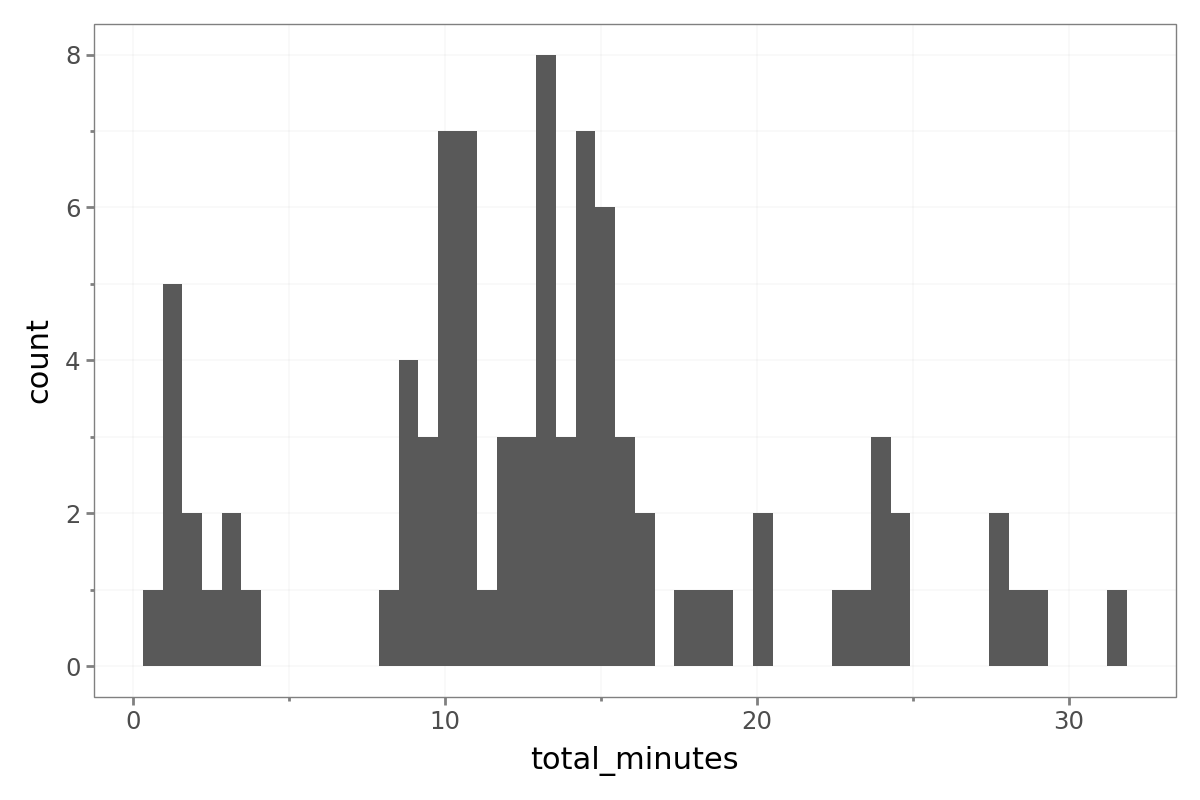

In [77]:
(
    pn.ggplot(
        data=(trials_df.with_columns(total_minutes=pl.col("time_total_s") / 60)),
        mapping=pn.aes("total_minutes"),
    )
    + pn.geom_histogram(bins=50)
    + theme_academic
)

In [78]:
best_hyperparams_df = (
    pl.read_csv("3_SARIMAX_trials.csv")
    .sort("loss")
    .head(1)
    .select(pl.selectors.contains("config/"))
    .unpivot()
    .with_columns(
        pl.col("variable").str.replace("config/", ""), pl.col("value").cast(pl.Int64)
    )
)

best_hyperparams = dict(
    zip(best_hyperparams_df["variable"], best_hyperparams_df["value"])
)

best_hyperparams

{'p': 7, 'q': 3, 'P': 0, 'Q': 1, 'd': 1, 'D': 1}

In [79]:
model = ARIMA(
    order=(
        best_hyperparams["p"],
        best_hyperparams["d"],
        best_hyperparams["q"],
    ),
    season_length=168,
    seasonal_order=(
        best_hyperparams["P"],
        best_hyperparams["D"],
        best_hyperparams["Q"],
    ),
)

# Fit the model on the full data
model = model.fit(
    y=y_train.to_numpy(dtype=np.float64),
    X=X_train_preprocessed.to_numpy(dtype=np.float64),
)

In [80]:
y_pred = validation(
    model=model,
    X_train=X_train_preprocessed,
    X_val=X_val_preprocessed,
    y_train=y_train,
    y_val=y_val,
)

y_preds_val = pd.DataFrame(
    {
        "pred": y_pred,
        "kWh": y_val,
    }
)

Hour 744 of 744


In [81]:
# Create the figure with step lines for both actual and predicted values
fig = px.line(
    y_preds_val.reset_index(),
    x="datetime",
    y=["kWh", "pred"],
    labels={
        "datetime": "Date",
        "value": "Energy Consumption (kWh)",
        "variable": "Series",
    },
    title="Actual vs Predicted Energy Consumption Over Time",
    line_shape="hv",  # Set line shape to horizontal-vertical for step chart
)

# Customize the layout
fig.update_layout(
    template="plotly_white",
    legend=dict(title=""),
    xaxis_title="Date",
    yaxis_title="Energy Consumption (kWh)",
)

# Show the figure
fig.show()

In [82]:
with open("autoarima_model.pkl", "rb") as f:
    model_summary = pickle.load(f)

In [83]:
best_hyperparams_autoarima = {
    "p": sum(1 for key in model_summary["coef"] if key.startswith("ar")),
    "q": sum(1 for key in model_summary["coef"] if key.startswith("ma")),
    "P": sum(1 for key in model_summary["coef"] if key.startswith("sar")),
    "Q": sum(1 for key in model_summary["coef"] if key.startswith("sma")),
    "d": 1,
    "D": 1,
}

best_hyperparams_autoarima

{'p': 20, 'q': 0, 'P': 0, 'Q': 0, 'd': 1, 'D': 1}

In [84]:
model = ARIMA(
    order=(
        best_hyperparams_autoarima["p"],
        best_hyperparams_autoarima["d"],
        best_hyperparams_autoarima["q"],
    ),
    season_length=168,
    seasonal_order=(
        best_hyperparams_autoarima["P"],
        best_hyperparams_autoarima["D"],
        best_hyperparams_autoarima["Q"],
    ),
)

# Fit the model on the full data
model = model.fit(
    y=y_train.to_numpy(dtype=np.float64),
    X=X_train_preprocessed.to_numpy(dtype=np.float64),
)

In [85]:
y_pred = validation(
    model=model,
    X_train=X_train_preprocessed,
    X_val=X_val_preprocessed,
    y_train=y_train,
    y_val=y_val,
)

y_preds_val = pd.DataFrame(
    {
        "pred": y_pred,
        "kWh": y_val,
    }
)

Hour 744 of 744


In [86]:
# Create the figure with step lines for both actual and predicted values
fig = px.line(
    y_preds_val.reset_index(),
    x="datetime",
    y=["kWh", "pred"],
    labels={
        "datetime": "Date",
        "value": "Energy Consumption (kWh)",
        "variable": "Series",
    },
    title="Actual vs Predicted Energy Consumption Over Time",
    line_shape="hv",  # Set line shape to horizontal-vertical for step chart
)

# Customize the layout
fig.update_layout(
    template="plotly_white",
    legend=dict(title=""),
    xaxis_title="Date",
    yaxis_title="Energy Consumption (kWh)",
)

# Show the figure
fig.show()

# Holdout Evaluation without Retraining

- fit the model once on the trainval set
- evaluate over the entire year and store predictions

In [87]:
best_hyperparams_df = (
    pl.read_csv("3_SARIMAX_trials.csv")
    .sort("loss")
    .head(1)
    .select(pl.selectors.contains("config/"))
    .unpivot()
    .with_columns(
        pl.col("variable").str.replace("config/", ""), pl.col("value").cast(pl.Int64)
    )
)

best_hyperparams = dict(
    zip(best_hyperparams_df["variable"], best_hyperparams_df["value"])
)

best_hyperparams

{'p': 7, 'q': 3, 'P': 0, 'Q': 1, 'd': 1, 'D': 1}

Do splits:

In [88]:
df_trainval = df_full["2022-09-01":"2023-08-31"]
df_holdout = df_full["2023-09-01":"2024-08-31"]

Preprocess the data:

In [89]:
X_trainval = df_trainval.drop(columns=["kWh"])
X_holdout = df_holdout.drop(columns=["kWh"])

X_trainval_preprocessed = pd.DataFrame(
    preprocessor.fit_transform(X_trainval),
    columns=preprocessor.get_feature_names_out(),
)

X_holdout_preprocessed = pd.DataFrame(
    preprocessor.transform(X_holdout),
    columns=preprocessor.get_feature_names_out(),
)

In [90]:
y_trainval = df_trainval["kWh"]
y_holdout = df_holdout["kWh"]

Fit model on the training and validation period:

In [91]:
# Fit model with best hyperparameters on history
model = ARIMA(
    order=(
        best_hyperparams["p"],
        best_hyperparams["d"],
        best_hyperparams["q"],
    ),
    season_length=168,
    seasonal_order=(
        best_hyperparams["P"],
        best_hyperparams["D"],
        best_hyperparams["Q"],
    ),
)

model = model.fit(
    y=y_trainval.to_numpy(dtype=np.float64),
    X=X_trainval_preprocessed.to_numpy(dtype=np.float64),
)

In [92]:
y_pred = validation(
    model=model,
    X_train=X_trainval_preprocessed,
    X_val=X_holdout_preprocessed,
    y_train=y_trainval,
    y_val=y_holdout,
    verbose=True,
)

Hour 8784 of 8784


In [93]:
y_preds_holdout = pd.DataFrame(
    {
        "pred": y_pred,
        "kWh": y_holdout,
    }
)

y_preds_holdout.head()

,pred,kWh
datetime,,
2023-09-01 00:00:00,4.998854e+06,4.952079e+06
2023-09-01 01:00:00,4.780058e+06,4.789383e+06
2023-09-01 02:00:00,4.668213e+06,4.689283e+06
2023-09-01 03:00:00,4.478623e+06,4.490485e+06
2023-09-01 04:00:00,4.359756e+06,4.345052e+06


In [94]:
(
    y_preds_holdout.reset_index().to_csv(
        "3_SARIMAX_holdout_predictions_no_retraining.csv", index=False
    )
)

In [95]:
# Create the figure with step lines for both actual and predicted values
fig = px.line(
    y_preds_holdout.reset_index(),
    x="datetime",
    y=["kWh", "pred"],
    labels={
        "datetime": "Date",
        "value": "Energy Consumption (kWh)",
        "variable": "Series",
    },
    title="Actual vs Predicted Energy Consumption Over Time",
    line_shape="hv",  # Set line shape to horizontal-vertical for step chart
)

# Customize the layout
fig.update_layout(
    template="plotly_white",
    legend=dict(title=""),
    xaxis_title="Date",
    yaxis_title="Energy Consumption (kWh)",
)

# Show the figure
fig.show()

# Holdout Evaluation with Retraining

Retrain weekly, then predict the entire following week without retraining.

- Training Size: Can not be much longer than a month, so go with that for now

In [96]:
best_hyperparams_df = (
    pl.read_csv("3_SARIMAX_trials.csv")
    .sort("loss")
    .head(1)
    .select(pl.selectors.contains("config/"))
    .unpivot()
    .with_columns(
        pl.col("variable").str.replace("config/", ""), pl.col("value").cast(pl.Int64)
    )
)

best_hyperparams = dict(
    zip(best_hyperparams_df["variable"], best_hyperparams_df["value"])
)

best_hyperparams

{'p': 7, 'q': 3, 'P': 0, 'Q': 1, 'd': 1, 'D': 1}

In [97]:
with open("autoarima_model.pkl", "rb") as f:
    model_summary = pickle.load(f)

best_hyperparams_autoarima = {
    "p": sum(1 for key in model_summary["coef"] if key.startswith("ar")),
    "q": sum(1 for key in model_summary["coef"] if key.startswith("ma")),
    "P": sum(1 for key in model_summary["coef"] if key.startswith("sar")),
    "Q": sum(1 for key in model_summary["coef"] if key.startswith("sma")),
    "d": 1,
    "D": 1,
}

best_hyperparams_autoarima

{'p': 20, 'q': 0, 'P': 0, 'Q': 0, 'd': 1, 'D': 1}

In [98]:
df_trainval = df_full["2022-09-01":"2023-08-31"]
df_holdout = df_full["2023-09-01":"2024-08-31"]

In [99]:
retraining_freq = 7 * 24
retraining_indices = np.arange(0, df_holdout.shape[0], retraining_freq).tolist()
y_preds_list = []
model_coefs_list = []

for holdout_index in tqdm(retraining_indices):

    # Preprocess training history df
    X_train = pd.concat(
        [
            df_trainval.iloc[holdout_index:].drop(columns=["kWh"]),
            df_holdout.iloc[:holdout_index].drop(columns=["kWh"]),
        ],
        axis=0,
    )
    X_train_preprocessed = pd.DataFrame(
        preprocessor.fit_transform(X_train),
        columns=preprocessor.get_feature_names_out(),
    )

    X_holdout = df_holdout.iloc[holdout_index : holdout_index + retraining_freq].drop(
        columns=["kWh"]
    )
    X_holdout_preprocessed = pd.DataFrame(
        preprocessor.transform(X_holdout),
        columns=preprocessor.get_feature_names_out(),
    )

    y_train = pd.concat(
        [
            df_trainval.iloc[holdout_index:]["kWh"],
            df_holdout.iloc[:holdout_index]["kWh"],
        ],
        axis=0,
    )
    y_holdout = df_holdout.iloc[holdout_index : holdout_index + retraining_freq]["kWh"]

    # Fit model with best hyperparameters on history
    model = ARIMA(
        order=(
            best_hyperparams["p"],
            best_hyperparams["d"],
            best_hyperparams["q"],
        ),
        season_length=168,
        seasonal_order=(
            best_hyperparams["P"],
            best_hyperparams["D"],
            best_hyperparams["Q"],
        ),
    )

    model = model.fit(
        y=y_train.to_numpy(dtype=np.float64),
        X=X_train_preprocessed.to_numpy(dtype=np.float64),
    )

    # Save the model coefficients for later visualisation
    model_coefs_list.append(pl.DataFrame(data=model.model_["coef"]))

    # Make predictions for that week and store them
    y_pred = validation(
        model=model,
        X_train=X_train_preprocessed,
        X_val=X_holdout_preprocessed,
        y_train=y_train,
        y_val=y_holdout,
        verbose=False,
    )

    y_preds_list.append(
        pd.DataFrame(
            {
                "pred": y_pred,
                "kWh": y_holdout,
            }
        )
    )

    # Increment holdout index
    holdout_index += retraining_freq

  0%|          | 0/53 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
(
    pd.concat(y_preds_list)
    .reset_index()
    .to_csv("3_SARIMAX_holdout_predictions_with_retraining.csv", index=False)
)

In [ ]:
loss = root_mean_squared_error(
    y_pred=pl.read_csv("3_SARIMAX_holdout_predictions_with_retraining.csv")["pred"],
    y_true=pl.read_csv("3_SARIMAX_holdout_predictions_with_retraining.csv")["kWh"],
)
loss

393242.6285374935

In [ ]:
pl.concat(model_coefs_list, how="vertical").to_pandas().to_csv(
    "3_SARIMAX_holdout_model_coefficients.csv"
)

In [ ]:
# Create the figure with step lines for both actual and predicted values
fig = px.line(
    pd.concat(y_preds_list).reset_index(),
    x="datetime",
    y=["kWh", "pred"],
    labels={
        "datetime": "Date",
        "value": "Energy Consumption (kWh)",
        "variable": "Series",
    },
    title="Actual vs Predicted Energy Consumption Over Time",
    line_shape="hv",  # Set line shape to horizontal-vertical for step chart
)

# Customize the layout
fig.update_layout(
    template="plotly_white",
    legend=dict(title=""),
    xaxis_title="Date",
    yaxis_title="Energy Consumption (kWh)",
)

# Show the figure
fig.show()